# ${\textbf{Melodi \& OMB vs WW3 in the LBE}}$  
In this Notebook, we assess the truthfulness of Melodi & OMB buoys in the LBE against WW3 during the two first weeks of May.  
4 OMB & 4 Melodi has been used

In [1]:
import xarray as xr
import shapefile as shp 
import numpy as np
import matplotlib.pyplot as plt
import SWOT_tools as st
import pandas as pd
from shapely.geometry import box
from shapely.wkt import loads  # In case your polygons are stored as WKT strings
import scipy 
from scipy.interpolate import griddata
from scipy.ndimage import binary_dilation
import matplotlib.patches as patches
from datetime import datetime
from tqdm import tqdm
import os

#plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})


In [2]:
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})

import matplotlib.font_manager as fm
# Regular and bold font paths
font_regular_path = "fonts/times/times.ttf"
font_bold_path = "fonts/times/timesbd.ttf"  # Bold
# Register both fonts
fm.fontManager.addfont(font_regular_path)
fm.fontManager.addfont(font_bold_path)
# Create font properties
font_regular = fm.FontProperties(fname=font_regular_path)
font_bold = fm.FontProperties(fname=font_bold_path)
# Set default font to regular Times New Roman
plt.rcParams['font.family'] = font_regular.get_name()

In [3]:
def pearson_correlation(x_obs, y_obs):
    x = np.array(x_obs)
    y = np.array(y_obs)
    
    x_bar = np.mean(x)
    y_bar = np.mean(y)

    numerator = np.sum((x - x_bar) * (y - y_bar))
    denominator = np.sqrt(np.sum((x - x_bar)**2) * np.sum((y - y_bar)**2))

    if denominator == 0:
        raise ValueError("Denominator is zero; correlation is undefined.")
    
    return numerator / denominator

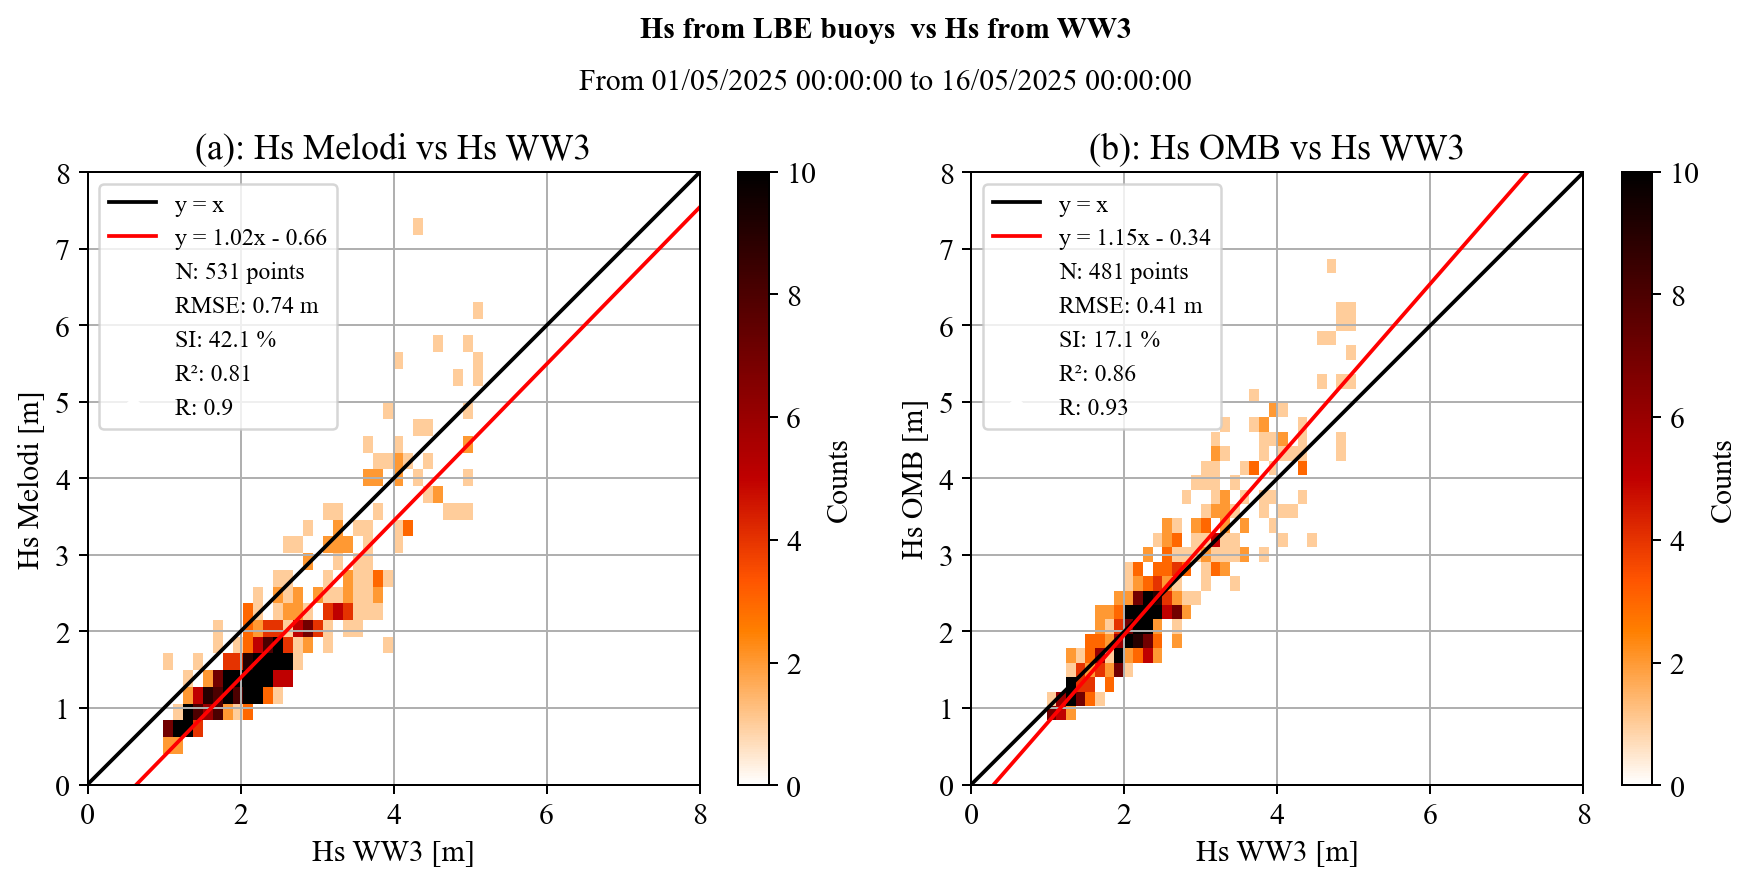

In [4]:
df_lbe_buoy = pd.read_csv(r"B_df/df_ww3_on_lofoten_buoys.csv")

plt.rcParams.update({'font.size': 12})  

fig, ax = plt.subplots(1,2, figsize = (10,5),dpi=180)


for i, b_type in enumerate(["m", "omb"]):
    #df = pd.read_csv("ww3_on_melodi.csv")
    df = df_lbe_buoy.dropna(subset=["WW3_Hs_on_b"])
    df = df.loc[df["b_type"] == b_type]

    if b_type == "m":
        letter = "a"
        name = "Melodi"
        window_med_filt = 23
        Hs_buoy_filtered = np.array([])
        for b_lab in np.unique(df["b_lab"].values):
            df_b_lab = df.loc[df["b_lab"] == b_lab]
            Hs_buoy_filtered_b_lab = scipy.signal.medfilt(df_b_lab["Hs_b"].values, window_med_filt) #+ 0.65
            Hs_buoy_filtered = np.concatenate((Hs_buoy_filtered, Hs_buoy_filtered_b_lab))
        
        
        #Hs_buoy_filtered = scipy.signal.medfilt(df["Hs_b"].values, window_med_filt) #+ 0.65
        x_obs, y_obs = df["WW3_Hs_on_b"].values[::window_med_filt], Hs_buoy_filtered[::window_med_filt]

    else: 
        letter = "b"
        name = "OMB"
        x_obs, y_obs = df["WW3_Hs_on_b"].values, df["Hs_b"].values
        
    R = pearson_correlation(x_obs, y_obs)
    RMSE = round(np.sqrt(np.mean((x_obs-y_obs)**2)),2)

    
    # DENSITY SCATTERPLOT REPLACEMENT
    _, _, _, imi = ax[i].hist2d(x_obs, y_obs, bins=32, cmap='gist_heat_r', vmin=0, vmax=10)
    fig.colorbar(imi, ax=ax[i], orientation='vertical', label='Counts', shrink=0.79)

    
    x_id, y_id = np.arange(0, 10, 0.1), np.arange(0, 10, 0.1)
    
    ax[i].plot(x_id, y_id, color="black", label="y = x")
    
    coeffs = np.polyfit(x_obs.flatten(), y_obs.flatten(), deg=1) 
    a, b = coeffs[0], coeffs[1]

    y_pred = a*x_obs+b
    R2 = round(1 - np.sum((y_obs - y_pred)**2) / np.sum((y_obs - np.mean(y_obs))**2), 2)

    N = x_obs.shape[0]

    SI = round(100* RMSE / np.mean(y_obs), 1)
    
    
    if b > 0:
        ax[i].plot(x_id, a*x_id+b,color="red",label=f"y = {round(a,2)}x + {round(b,2)}")
    else: 
        ax[i].plot(x_id, a*x_id+b,color="red",label=f"y = {round(a,2)}x - {round(abs(b),2)}")


    plt.rcParams.update({'font.size': 9.5})  
    ax[i].scatter(-1,-1, color="white", label=f"N: {N} points")    
    ax[i].scatter(-1,-1, color="white", label=f"RMSE: {RMSE} m")
    ax[i].scatter(-1,-1, color="white", label=f"SI: {SI} %")
    ax[i].scatter(-1,-1, color="white", label=f"R²: {R2}")
    ax[i].scatter(-1,-1, color="white", label=f"R: {round(R,2)}")
    ax[i].legend(loc="upper left")

    #ax[i].scatter(-1,-1, color="white", label=f"R²_p: {round(R**2,2)}")

    plt.rcParams.update({'font.size': 12})  
    ax[i].grid()
    ax[i].axis('scaled')
    ax[i].set_xlim(0,8)
    ax[i].set_ylim(0,8)
    ax[i].set_title(f"({letter}): Hs {name} vs Hs WW3")
    #fig.text(0.5, 0.875, " Start IW: {} --- End IW: {} \n Start SWOT: {} --- End SWOT: {} \n ".format(dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S'), t_ini_swot_formatted, t_end_swot_formatted), ha='center', fontsize=11)
    ax[i].set_xlabel("Hs WW3 [m]")
    ax[i].set_ylabel(f"Hs {name} [m]")
    #plt.xlim(min_xx,max_xx)
    #plt.ylim(min_xx,max_xx)
    #plt.xlim(hs_min,hs_max)
    #plt.ylim(hs_min,hs_max)

    #N_colocs.append(np.unique(df_hs_EXT["swot_file"]).shape[0])
    
#ax[0].set_title(f"(a) ALL FILES: {N_colocs[0]} co-loc cases")
#ax[1].set_title(f"(b) PIC2: {N_colocs[1]} co-loc cases")
#ax[2].set_title(f"(c) PIC0, PGC0: {N_colocs[2]} co-loc cases")
fig.text(x=0.5,y=0.9,s="From 01/05/2025 00:00:00 to 16/05/2025 00:00:00", ha="center")
plt.suptitle("Hs from LBE buoys  vs Hs from WW3", fontproperties=font_bold, fontsize=12)# \n Start IW: {} --- End IW: {} \n Start SWOT: {} --- End SWOT: {} \n ".format(pretitle, dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S'), t_ini_swot_formatted, t_end_swot_formatted))
plt.tight_layout()
plt.savefig("output_images/LF/scatter_plot_buoy.png")